In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as si
import numpy.linalg as npla
import scipy.linalg
from scipy.linalg import solve_banded


import pandas as pd
from scipy.sparse.csc import csc_matrix

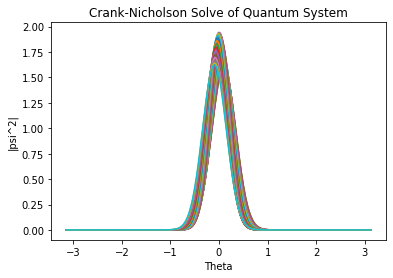

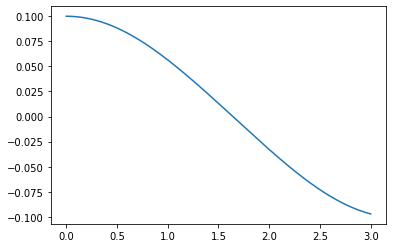

C:\Users\reddf\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


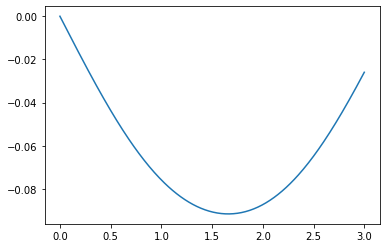

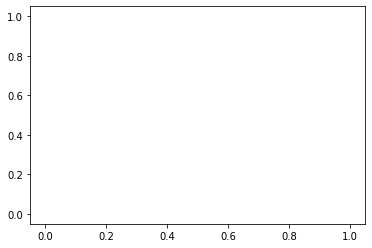

In [2]:
#Wigner/Husini function implementation
#Particle on ring Dimensionless


#variables
Omeg0=1.0
Omeg1=1.0
eps=0.07
ntild=10#ntild = 1 is quantum, ntild>>1 is classical
dt=0.01
nsteps=300
isteps=300

t0=0
theta0=0+0.1
thetamin=-np.pi
thetamax=np.pi
k=1j

#dependent variables
dtheta=(2*thetamax)/isteps
sigma=0.5

#initial arrays 
theta=np.zeros(isteps)
drv=np.zeros(nsteps+1)
t=np.zeros(nsteps+1)
   
for n in range(nsteps+1):#t,drv array, drv is drive force
    tn=t0+(n)*dt
    t[n]=tn
    drvn=np.cos(Omeg1*tn)
    drv[n]=drvn

Psi=np.zeros(isteps,np.complex)#wave packet array

for i in range(0,isteps):#theta,initial wave packet array T
    thetai=thetamin+(i)*dtheta
    theta[i]=thetai
    Psii=np.exp((-0.0*k*thetai)+(-1)*((thetai-theta0)**2)/(sigma)**2)
    Psi[i]=Psii
    
#probibility here, to normalize
Total=np.sum(np.abs(Psi)**2)*dtheta
Psi=Psi/(np.sqrt(Total))
#make array of arrays of T
Psin=[]
Psin.append(Psi)

#definitions of coeffients
def a(drv,theta):
    a1=((1/(ntild*2*2*(dtheta)**2))-((k*eps*(Omeg0/Omeg1)*drv[n])/(dtheta)))
    return a1
def b(drv,theta):
    b1=((k/(Omeg0*dt))+(1/(ntild*2*(dtheta)**2))+((eps**2)/2+(Omeg0**2)/(Omeg1**2)*ntild*(drv[n])**2/4)-(ntild*np.cos(theta)/2))#cos has flipped signs, fix this and correct the potential
    return b1 
def c(drv,theta):
    c1=((1/(ntild*2*2*(dtheta)**2))+((k*eps*(Omeg0/Omeg1)*drv[n])/(dtheta)))
    return c1

def a_1(drv,theta):
    a_11=((1/(ntild*2*2*(dtheta)**2))-((k*eps*(Omeg0/Omeg1)*drv[n+1])/(dtheta)))
    return a_11
def b_1(drv,theta):
    b_11=((k/(Omeg0*dt))-(1/(ntild*2*(dtheta)**2))-((eps**2)/2+(Omeg0**2)/(Omeg1**2)*ntild*(drv[n+1])**2/4)+(ntild*np.cos(theta)/2))#cos has flipped signs, fix this and correct the potential
    return b_11
def c_1(drv,theta):
    c_11=((1/(ntild*2*2*(dtheta)**2))+((k*eps*(Omeg0/Omeg1)*drv[n+1])/(dtheta)))
    return c_11

def CrankNicolson(Psi,n):#Crank nicolson solver with periodic boundary conditions
    RHS=np.zeros(isteps,np.complex)#RHS
    for i in range(-1,isteps-1):
        temp1=-a(drv,theta[i])
        temp2=b(drv,theta[i])
        temp3=-c(drv,theta[i])
        RHS[i]=temp1*Psi[i+1]+temp2*Psi[i]+temp3*Psi[i-1]
    D=np.matrix(RHS).T#made matrix for the RHS
    d=np.zeros((3,isteps),np.complex)#LHS
    for i in range(-1,isteps-1):#make the banded matrix
        d[1,i]=b_1(drv,theta[i])
        d[2,i]=a_1(drv,theta[i])
        d[0,i]=c_1(drv,theta[i])
    d=np.matrix(d)#made matrix for LHS
    #d=np.zeros((isteps,isteps),np.complex)#LHS
    #for i in range(-1,isteps-1):
     #   d[i,i]=b_1(drv,theta[i])
      #  d[i,i+1]=a_1(drv,theta[i])
       # d[i,i-1]=c_1(drv,theta[i])
    #print(d)
    #print(d.shape)
    #I=npla.inv(d)#matrix inversion using linear algebra 
    #T1=I*D
    #T1=np.array(T1.T)[0]#add to array of T
    Psi1=scipy.linalg.solve_banded((1,1),d,D)
    return Psi1

#plt.plot(theta,np.real(T))# plots initial condition
#Run for all t
for n in range(nsteps):#Plots real parts                                                                  
    Psi=CrankNicolson(Psi,n)
    Psin.append(Psi)
 #   plt.plot(theta,np.real(T))
    
#plt.show() 

#for T in Tn:#Plots imaginary parts
  #  plt.plot(theta,np.imag(T))

#plt.show()

#for T in Tn:#plots overall average
   # plt.plot(theta,np.abs(T)**2)
   #print(np.sum(np.abs(T)**2)*dtheta)#checking for unitarity

for n in range(0,nsteps,10):
    plt.plot(theta,np.abs(Psin[n])**2)
plt.title('Crank-Nicholson Solve of Quantum System')
plt.xlabel('Theta')
plt.ylabel('|psi^2|')
plt.show()

#Expecatation values

def position(theta,Psi):#calculates expectation value
    TA=0.
    for i in range(isteps):
        TA=TA+theta[i]*(np.abs(Psi[i])**2)*dtheta
    return TA

xbar=np.zeros(nsteps+1)
for n in range(nsteps+1):
    xbar[n]=np.real(position(theta,Psin[n]))
    
#print(xbar[0])
plt.plot(t,xbar)
plt.show()

#angular momentum value, this works as long as Omeg0=1, which it does
Exp_momentum=np.zeros((nsteps+1,2),np.complex)
def momentum(Psi):#calculates expectation value
    P=0.
    for i in range(-1,isteps-1):
        P=P+(1)*(-k)*(Omeg0/ntild)*np.conj(Psi[i])*((Psi[i+1]-Psi[i-1])/(2*dtheta))*dtheta
    return(P)

pbar=np.zeros((nsteps+1),np.complex)
#
for n in range(nsteps+1):
    pbar[n]=np.real(momentum(Psin[n]))
    Exp_momentum[n,0]=t[n]#time
    Exp_momentum[n,1]=momentum(Psin[n])#expectation value of momentum

Exp_momentum=np.matrix(Exp_momentum)#table showing time and expectation value
#print(pbar)
plt.plot(t,pbar)
plt.show()

#print(T)

#poincare surface of sections with expectation values 
V_qm=[]
X_qm=[]

ICsP=int((2*np.pi)/(dt*Omeg1))
Max=nsteps-ICsP

for n in range(nsteps):
    P_Xqm=np.zeros(nsteps)#Max-ICsP)
    P_Vqm=np.zeros(nsteps)#Max-ICsP)
    pbar[n]=np.real(momentum(Psin[n]))
    xbar[n]=np.real(position(theta,Psin[n]))
    V_qm.append(pbar)
    X_qm.append(xbar)
    for k in range(ICsP,Max,ICsP): # turn this loop into the POINCARE SURFACES
        P_Xqm[k-ICsP] = X_qm[n][k]
        P_Vqm[j-ICsP] = V_qm[n][k]
        P_Xqm=((P_Xqm+np.pi)%(2*np.pi))-np.pi
    #plt.plot(P_Xqm,P_Vqm,',')
plt.plot()
plt.show()
#print(len(theta))

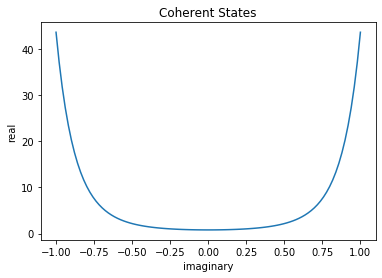

In [14]:
#here we will integrate the coherent states. I will use the same
#method used to integrate the husini function bellow

alpha = 1 + 1j
sigma_coherent = 0.5
real_alpha = np.linspace(-np.abs(np.real(alpha)), np.abs(np.real(alpha)), 100, np.complex)
imaginary_alpha =  np.linspace(-np.abs(np.imag(alpha)), np.abs(np.imag(alpha)), 100, np.complex)
x_alpha = np.linspace(-np.real(alpha), np.real(alpha), 100)

ksteps = 100

def coherent_state(real_alpha0, imaginary_alpha0,x_alpha0):
    return (1/((2*np.pi)**(1/4)*(sigma_coherent)**(1/2)))*np.exp((((imaginary_alpha0*x_alpha0)/(sigma_coherent))-((np.abs(x_alpha0-2*sigma_coherent*real_alpha0)**2/(4*sigma_coherent**2)))))
    
#integral_func = coherent_state(real_alpha1,imaginary_alpha1,x_alpha1)

Int_alpha=np.zeros(ksteps,np.complex)
for k in range(ksteps):
    Int_alpha[k]=coherent_state(real_alpha[k], imaginary_alpha[k], x_alpha[k])
        
plt.plot(x_alpha,np.abs(Int_alpha)**2)#blue
plt.title('Coherent States')
plt.xlabel('imaginary')
plt.ylabel('real')
plt.show()

In [ ]:
#print(len(theta))
#print(max(pbar))
omega=np.linspace(-min(pbar),min(pbar),len(theta))
theta=theta
r=np.linspace(-np.pi,np.pi,len(theta))

#print(omega)
#print(len(theta))
#psi=CrankNicolson(T,n)

dr=2

omega1,theta1,r1=np.meshgrid(omega,theta,r)
omega2,theta2=np.meshgrid(omega,theta)
#theta3,x3=np.meshgrid(theta,x)
#print(x1,y1)
#print(x,y)

wsteps=len(omega)
jsteps=len(theta)

def Husimi(omega0,theta0,r0):
    return np.exp((k*ntild*omega0*r)-(((theta0-r0)**2)/(4*(dr**4))))*Psi

func=Husimi(omega1,theta1,r1)

#print(func.shape)
#print(omega)
#print(theta)
#plt.plot(z)
#plt.show()

#plt.contour(x1,y1,z)
#plt.show()


#print(x[0])
#print(z)
#print(omega.shape)
#print(theta.shape)
#print(z.shape)


Int=np.zeros((wsteps,jsteps),np.complex)
for w in range(wsteps):
    for j in range(jsteps):
        Int[w,j]=si.simps(func[j,:,w],r)#,np.pi/2,-1,'avg')
        
#print(Int)
#print(Int.shape)
#print(omega2.shape)

plt.contour(np.real(omega2),np.real(theta2),np.abs(Int)**2)#blue
plt.title('Quantum Solution (Husini Function)')
plt.xlabel('Theta')
plt.ylabel('Omega')
plt.show()



In [ ]:
#variables in the classical scheme
tn=0
xn=0# Theta initial
vn=0# Omega/ angular velocity initial
nsteps=1000000
v=np.zeros(nsteps)
x=np.zeros(nsteps)
t=np.zeros(nsteps)
isteps=10# number of initial conditions we need
i=1+isteps
V=[]
X=[]
T=[]

def Verlet(tn,xn,vn,dt):#velocity verlet algorithim
    tn1=tn+dt
    an=(-Omeg0**2)*math.sin(xn)+eps*math.sin(Omeg1*tn)
    xn1=xn+vn*dt+(1/2)*an*dt**2# position
    an1=(-Omeg0**2)*math.sin(xn1)+eps*math.sin(Omeg1*tn1)# acceleration
    vn1=vn+(1/2)*(an+an1)*dt# velocity
    return tn1,xn1,vn1

ICsP=int((2*np.pi)/(dt*Omeg1))
Max=nsteps-ICsP

for i in range(10):
    P_X=np.zeros(nsteps)#Max-ICsP)
    P_V=np.zeros(nsteps)#Max-ICsP)
    tn=0
    xn=(np.pi/4)#*i
    vn=(np.pi/4)*(i-4)
    for n in range(nsteps):#looping verlet to get values
        tn, xn, vn = Verlet(tn,xn,vn,dt)
        x[n]=xn
        v[n]=vn
        t[n]=tn
    X.append(x.copy())
    V.append(v.copy())
    T.append(t)
    for j in range(ICsP,Max,ICsP): # turn this loop into the POINCARE SURFACES
        P_X[j-ICsP] = X[i][j]
        P_V[j-ICsP] = V[i][j]
        P_X=((P_X+np.pi)%(2*np.pi))-np.pi
    plt.plot(P_X,P_V,',')
    
plt.title('Classical Solution')
plt.xlabel('Theta')
plt.ylabel('Omega')
plt.show()


In [ ]:
#for i in range(10):
 #   P_X=np.zeros(nsteps)#Max-ICsP)
  #  P_V=np.zeros(nsteps)#Max-ICsP)
   # tn=0
    #xn=(np.pi/4)#*i
   # vn=(np.pi/4)*(i-4)
    #for j in range(ICsP,Max,ICsP): # turn this loop into the POINCARE SURFACES
     #   P_X[j-ICsP] = X[i][j]
      #  P_V[j-ICsP] = V[i][j]
       # P_X=((P_X+np.pi)%(2*np.pi))-np.pi

plt.figure(figsize=(8,6))
plt.contour(np.real(omega2),np.real(theta2),np.abs(Int)**2)
for i in range(10):
    P_X=np.zeros(nsteps)#Max-ICsP)
    P_V=np.zeros(nsteps)#Max-ICsP)
    for j in range(ICsP,Max,ICsP): # turn this loop into the POINCARE SURFACES
        P_X[j-ICsP] = X[i][j]
        P_V[j-ICsP] = V[i][j]
        P_X=((P_X+np.pi)%(2*np.pi))-np.pi        
    plt.plot(P_X,P_V, ',')#marker
plt.show()